In [73]:
import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from isyatirimhisse import StockData, Financials

In [621]:
financials = Financials()
df = financials.get_data(
    symbols='BRSAN',
    start_year='2013',
    save_to_excel=True
)


Data saved to financials_20240831


In [622]:
bilanco=pd.read_excel("financials_20240831.xlsx")

In [624]:
current_liabilities=bilanco[bilanco['itemDescTr'].str.contains('yükümlülük', case=False, na=False)].iloc[:4,3:].sum(axis=0)
total_liabilities=bilanco[bilanco['itemDescTr'].str.contains('yükümlülük', case=False, na=False)].iloc[:,3:].sum(axis=0)

In [625]:
current_assets = bilanco.loc[bilanco['itemDescEng'] == 'CURRENT ASSETS'].values[0][3:]
total_assets = bilanco.loc[bilanco['itemDescEng'] == 'TOTAL ASSETS'].values[0][3:]
shareholders_equity = bilanco.loc[bilanco['itemDescEng'] == 'SHAREHOLDERS EQUITY'].values[0][3:]
net_profit_after_taxes = bilanco.loc[bilanco['itemDescEng'] == 'NET PROFIT AFTER TAXES'].values[0][3:]
domestic_sales = bilanco.loc[bilanco['itemDescEng'] == 'Domestic Sales'].values[0][3:]
export_sales = bilanco.loc[bilanco['itemDescEng'] == 'Export Sales'].values[0][3:]
netkar=bilanco.loc[bilanco['itemDescTr'] == 'Dönem Net Kar/Zararı'].values[0][3:]
özkaynaklar=bilanco.loc[bilanco['itemDescTr'] == 'Özkaynaklar'].values[0][3:]
satışlar=bilanco.loc[bilanco['itemDescTr'] == 'Satış Gelirleri'].values[0][3:]
brütkar=bilanco.loc[bilanco['itemDescTr'] == 'BRÜT KAR (ZARAR)'].values[0][3:]
faaliyetkarı=bilanco.loc[bilanco['itemDescTr'] == 'FAALİYET KARI (ZARARI)'].values[0][3:]
# Calculate the ratios
current_ratio = current_assets / current_liabilities
debt_to_equity_ratio = total_liabilities / shareholders_equity
return_on_equity = net_profit_after_taxes / shareholders_equity
net_profit_margin = net_profit_after_taxes / satışlar
roe=netkar/özkaynaklar
asset_turnover=satışlar/total_assets
brütkarmarjı=brütkar/satışlar
faaliyetkarmarj=faaliyetkarı/satışlar

def tolist(array):
    array=pd.DataFrame(array).reset_index()
    del array["index"]
    return array
current_ratio=tolist(current_ratio)
debt_to_equity_ratio=tolist(debt_to_equity_ratio)
return_on_equity=tolist(return_on_equity)
net_profit_margin=tolist(net_profit_margin)
roe=tolist(roe)
asset_turnover=tolist(asset_turnover)
brütkarmarjı=tolist(brütkarmarjı)
faaliyetkarmarj=tolist(faaliyetkarmarj)
satışlar=tolist(satışlar)
netkar=tolist(netkar)
current_assets=tolist(current_assets)
total_assets=tolist(total_assets)
net_profit_after_taxes=tolist(net_profit_after_taxes)
özkaynaklar=tolist(özkaynaklar)
brütkar=tolist(brütkar)
faaliyetkarı=tolist(faaliyetkarı)

In [626]:
hisse=yf.download(tickers="BRSAN.IS",start="2013-01-02",interval="1wk")
hisse = hisse.resample('Q').agg({'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'mean',
    'Volume': 'sum'
})
hisse["Return"]=((hisse["Close"].shift(-2)/hisse["Close"])-1)*100

[*********************100%***********************]  1 of 1 completed


In [627]:
rasyo=pd.concat([current_ratio,debt_to_equity_ratio,return_on_equity,net_profit_margin,roe,asset_turnover,brütkarmarjı,faaliyetkarmarj,satışlar,netkar,current_assets,total_assets,net_profit_after_taxes,özkaynaklar,brütkar,faaliyetkarı],axis=1)
rasyo.columns=["Cari Oran","Borçluluk Oranı","Return On Equity","Net Kar Marjı","ROE","Devir Hızı","Brüt Kar Marjı","Faaliyet Kar Marjı","s","n","c","t","favök","özkaynak","brütkar","faaliyetkarı"]
rasyo["Fiyat"]=hisse["Close"].values[:-1]
rasyo["Return"]=hisse["Return"].values[:-1]
rasyo=rasyo.set_index(pd.date_range(start="2010-03-31",freq="Q",periods=len(rasyo)))
rasyo=rasyo.iloc[2:,:]
rasyo["Return"]=rasyo["Return"].fillna(0)


In [628]:
rasyo=rasyo.astype(float)

In [629]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
rasyo_scaled=scaler.fit_transform(rasyo.iloc[:,:-1])
rasyo_scaled=pd.DataFrame(rasyo_scaled,columns=rasyo.columns[:-1])
rasyo_scaled["Return"]=rasyo["Return"].values


In [630]:
X=rasyo_scaled.drop("Return",axis=1)
X=rasyo_scaled.drop(X.columns[-9:-2],axis=1)
y=rasyo_scaled["Return"]
X_train, y_train = X[:-12], y[:-12]
X_test, y_test = X[-12:], y[-12:]

In [ ]:
from lazypredict.Supervised import LazyRegressor
reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None )
models,predictions = reg.fit(X_train, X_test, y_train, y_test)

In [297]:
predictions

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
Lars,1615511077.23,-881187858.76,773032.79,0.02
RANSACRegressor,1261572.62,-688128.97,21602.25,0.12
LinearRegression,9861.86,-5377.65,1909.85,0.01
TransformedTargetRegressor,9861.86,-5377.65,1909.85,0.01
HuberRegressor,2536.78,-1382.15,968.50,0.05
LassoLarsIC,1629.99,-887.54,776.25,0.02
KernelRidge,237.14,-127.80,295.55,0.01
Ridge,227.11,-122.33,289.20,0.01
PassiveAggressiveRegressor,179.93,-96.60,257.27,0.01


In [ ]:
import optuna
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor


def objective(trial):
    # Define the hyperparameters to be tuned
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1.0, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)

    # Create the model with the suggested hyperparameters
    model = GradientBoostingRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        subsample=subsample,
        random_state=42
    ).fit(X_train,y_train)
    predictions=model.predict(X_test)

    tahminler=pd.DataFrame()
    tahminler["Hedef Fiyat"]=hisse["Close"][-13:-2]*(1+(predictions[:-1]/100))
    tahminler["Gerçekleşen Fiyat"]=hisse["Close"].loc["2022-03-31":].values

    return np.sqrt(mean_squared_error(tahminler["Gerçekleşen Fiyat"][:-1],tahminler["Hedef Fiyat"][:-1]))

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

# Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)
print("Best score: ", study.best_value)

In [632]:
from sklearn.ensemble import GradientBoostingRegressor
params=study.best_params
model = GradientBoostingRegressor(**params,random_state=42
    ).fit(X_train,y_train)
predictions=model.predict(X_test)

In [633]:
tahminler=pd.DataFrame()
tahminler["Hedef Fiyat"]=hisse["Close"][-13:-2]*(1+(predictions[:-1]/100))
tahminler["Gerçekleşen Fiyat"]=hisse["Close"].loc["2022-03-31":].values
tahminler

,Hedef Fiyat,Gerçekleşen Fiyat
Date,,
2021-09-30,26.18,26.10
2021-12-31,31.41,30.95
2022-03-31,46.93,44.86
2022-06-30,60.75,69.52
2022-09-30,74.19,80.11
2022-12-31,136.47,183.04
2023-03-31,157.25,524.22
2023-06-30,359.31,746.15
2023-09-30,637.31,640.54


In [634]:
hisse=yf.download(tickers="BRSAN.IS",start="2022-01-01",interval="1wk")
hisse["Date"]=pd.to_datetime(hisse.index)
hisse["Q"]=hisse["Date"].dt.quarter
hisse["Year"]=hisse["Date"].dt.year
hisse

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Date,Q,Year
Date,,,,,,,,,
2022-01-03,27.40,28.36,27.06,27.16,27.16,3748758,2022-01-03,1,2022
2022-01-10,27.26,27.60,26.54,26.88,26.88,2480137,2022-01-10,1,2022
2022-01-17,26.96,27.82,25.52,26.08,26.08,3649896,2022-01-17,1,2022
2022-01-24,26.08,26.16,24.00,25.50,25.50,2950239,2022-01-24,1,2022
2022-01-31,25.70,28.24,25.48,27.06,27.06,5807391,2022-01-31,1,2022
...,...,...,...,...,...,...,...,...,...
2024-07-29,446.75,446.75,412.00,417.25,417.25,2694921,2024-07-29,3,2024
2024-08-05,380.00,417.50,380.00,390.00,390.00,2299790,2024-08-05,3,2024
2024-08-12,386.25,394.50,358.50,370.75,370.75,3563926,2024-08-12,3,2024


In [635]:
hisse["Hedef"]=0
hisse["Hedef"].loc[(hisse.index<tahminler.index[2]) & (hisse.index>tahminler.index[1])]=tahminler["Hedef Fiyat"].iloc[0]
hisse["Hedef"].loc[(hisse.index<tahminler.index[2]) & (hisse.index>tahminler.index[1])]=tahminler["Hedef Fiyat"].iloc[0]
for i in range(3,len(tahminler)):
    hisse["Hedef"].loc[(hisse.index<tahminler.index[i]) & (hisse.index>tahminler.index[i-1])]=tahminler["Hedef Fiyat"].iloc[i-2]
hisse["Hedef"].loc["2024-04-01":"2024-06-30"]=tahminler["Hedef Fiyat"].iloc[-2]
hisse["Hedef"].loc["2024-07-01":]=tahminler["Hedef Fiyat"].iloc[-1]


In [642]:
hisse

,Open,High,Low,Close,Adj Close,Volume,Date,Q,Year,Hedef
Date,,,,,,,,,,
2022-01-03,27.40,28.36,27.06,27.16,27.16,3748758,2022-01-03,1,2022,26.18
2022-01-10,27.26,27.60,26.54,26.88,26.88,2480137,2022-01-10,1,2022,26.18
2022-01-17,26.96,27.82,25.52,26.08,26.08,3649896,2022-01-17,1,2022,26.18
2022-01-24,26.08,26.16,24.00,25.50,25.50,2950239,2022-01-24,1,2022,26.18
2022-01-31,25.70,28.24,25.48,27.06,27.06,5807391,2022-01-31,1,2022,26.18
...,...,...,...,...,...,...,...,...,...,...
2024-07-29,446.75,446.75,412.00,417.25,417.25,2694921,2024-07-29,3,2024,418.82
2024-08-05,380.00,417.50,380.00,390.00,390.00,2299790,2024-08-05,3,2024,418.82
2024-08-12,386.25,394.50,358.50,370.75,370.75,3563926,2024-08-12,3,2024,418.82


In [640]:
yeni

,Hedef
2024-07-01,418.82
2024-07-08,418.82
2024-07-15,418.82
2024-07-22,418.82
2024-07-29,418.82
2024-08-05,418.82
2024-08-12,418.82
2024-08-19,418.82
2024-08-26,418.82
2024-09-01,418.82


In [639]:
yeni=pd.DataFrame({"Hedef":[tahminler["Gerçekleşen Fiyat"].iloc[-2]*(1+(predictions[-1]/100))]})
yeni = pd.concat([yeni] * 17, ignore_index=True)
yeni=yeni.set_index(pd.date_range(start="2024-09-01",freq="W",periods=len(yeni)))
yeni.loc["2024-09-01":"2024-09-30"]=hisse["Hedef"].iloc[-1]
yeni=pd.concat([hisse["Hedef"].loc["2024-07-01":],yeni],axis=0)

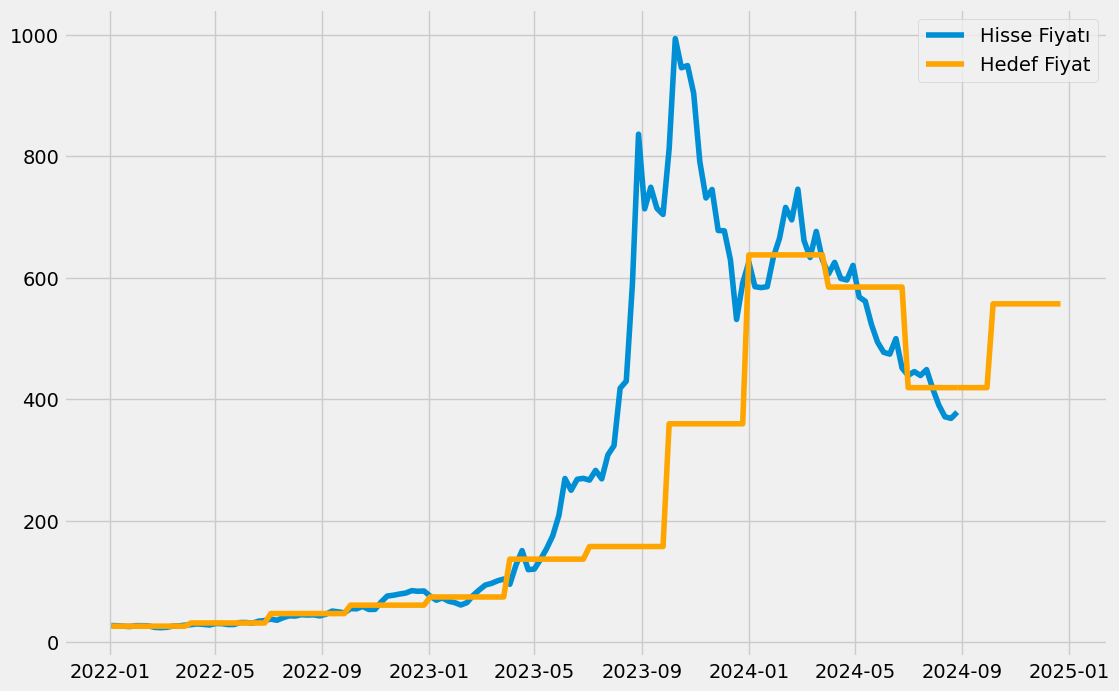

In [641]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(12,8))
plt.plot(hisse["Close"],label="Hisse Fiyatı")
plt.plot(hisse["Hedef"],label="Hedef Fiyat",color="orange")
plt.plot(yeni["Hedef"].loc["2024-08-26":],color="orange")
#plt.scatter(x=pd.date_range(start="2022-02-15",freq="M",end="2024-08-31")[::3],y=hisse["Close"].resample("Q").mean(),color="red",zorder=3,s=100,label="Çeyreklik Ortalama Fiyat")
plt.legend()

In [127]:
tahminler

,Hedef Fiyat,Gerçekleşen Fiyat
Date,,
2021-06-30,17.08,18.06
2021-09-30,17.03,20.07
2021-12-31,19.04,20.05
2022-03-31,18.80,19.82
2022-06-30,24.38,31.91
2022-09-30,24.11,33.92
2022-12-31,29.14,35.22
2023-03-31,42.46,52.86
2023-06-30,42.85,54.93
